In [55]:
import pandas as pd
import numpy as np
from IPython.display import display
from sklearn.preprocessing import MinMaxScaler
from semopy import Model, calc_stats, semplot
from statsmodels.stats.outliers_influence import variance_inflation_factor
import warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt

In [56]:
df = pd.read_spss('C:\\data\\education\\한국아동청소년행복지수조사\\kor_data_20210010.sav')
df.head(3)

,id,sex,birthy,birthm,area,size,school,grade,home1,home2,...,q512,q513,q514,q52,q53,q5411,q5412,q5421,q5422,wt
0,20001.0,여성,2003.0,4월,"충청권(대전, 충남, 충북)",도서벽지 및 읍면지역,고등학생,3학년,아니오,아니오,...,해당 없음,차이 없음,차이 없음,28.0,그대로다,NaN,NaN,NaN,NaN,0.250048
1,20002.0,여성,2003.0,8월,"충청권(대전, 충남, 충북)",도서벽지 및 읍면지역,고등학생,3학년,예,예,...,차이 없음,차이 없음,차이 없음,20.0,그대로다,NaN,NaN,NaN,NaN,0.250048
2,20003.0,여성,2003.0,9월,"충청권(대전, 충남, 충북)",도서벽지 및 읍면지역,고등학생,3학년,예,예,...,차이 없음,차이 없음,차이 없음,30.0,그대로다,NaN,NaN,NaN,NaN,0.250048


In [57]:
def null0(df):
    """
    결측치가 있는 열을 0으로 채우는 함수
    """
    for col in df.columns:
        if df[col].isnull().sum() > 0:
            df[col] = df[col].fillna(0)
    return df


In [58]:


def encoding(df, columns, category_map): 
    df[columns] = df[columns].replace(category_map)
    return df
category4_map = {
    '전혀 그렇지 않다': 0,
    '그렇지 않다': 1,
    '그렇다': 2,
    '매우 그렇다': 3
}
category5_map = {
    '전혀 그렇지 않다': 0,
    '별로 그렇지 않다': 1,
    '보통이다' : 2,
    '조금 그렇다': 3,
    '매우 그렇다': 4
}
reverse_category5_map = {
    '전혀 그렇지 않다': 4,
    '별로 그렇지 않다': 3,
    '보통이다' : 2,
    '조금 그렇다': 1,
    '매우 그렇다': 0
}
how_serious_map = {
    '전혀 심각하지 않다' : 0,
    '별로 심각하지 않다' : 1,
    '보통이다' : 2,
    '약간 심각한 편이다' : 3,
    '매우 심각하다' : 4
}
how_often_map = {
'경험이 전혀 없거나 거의 없었다' : 2,
'1년에 몇 번 있었다' : 1,
'한 달에 몇 번 있었다' : 0,
'일주일에 한번 이상 있었다' : 0 
}
happy_map = {
'매우 행복하다' : 4,
'대체로 행복한 편이다' : 3,
'모르겠다' : 2,
'별로 행복하지 않은 편이다' : 1,
'전혀 행복하지 않다' : 0
}
how_happy_map = {
'매우 행복하다' : 4,
'약간 행복하다' : 3,
'보통이다' : 2,
'약간 불행하다' : 1,
'매우 불행하다' : 0
}
yes_or_no_map = {
'예' : 1,
'아니오' : 0
}

In [59]:
def time_min(df, hour_column, minute_column):
    # 시간과 분 열의 결측값을 0으로 채움
    df[hour_column] = df[hour_column].fillna(0)
    df[minute_column] = df[minute_column].fillna(0)
    
    # 데이터 타입을 float로 변환
    df[hour_column] = df[hour_column].astype(float)
    df[minute_column] = df[minute_column].astype(float)

    # 총 분 계산
    df['pri_edu_time'] = df[hour_column] * 60 + df[minute_column]
    return df


In [60]:
def not_applicable(df, columns):
    for col in columns:
        df[col] = df[col].replace({'해당사항 없음': '보통이다'})
    return df

In [61]:
def weighted_cov(X, weights):
    average = np.average(X, axis=0, weights=weights)
    X_centered = X - average
    cov_matrix = np.dot((X_centered * weights[:, None]).T, X_centered) / (weights.sum() - 1)
    return cov_matrix

In [62]:
def calculate_covariance(df, observed_vars):
    data_for_cov = df[observed_vars].apply(pd.to_numeric, errors='coerce')
    weights = df['wt'].to_numpy()
    w_cov = weighted_cov(data_for_cov.to_numpy(), weights)
    return pd.DataFrame(w_cov, index=observed_vars, columns=observed_vars)

In [63]:
def compute_vif(df, observed_vars):
    X = df[observed_vars].apply(pd.to_numeric, errors='coerce').dropna()
    vif_data = pd.DataFrame()
    vif_data["Feature"] = X.columns
    vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
    return vif_data

In [64]:
def fit_sem_model(model, df, w_cov_df):
    model.fit(df, cov=w_cov_df)
    return model

# 학업압박

In [65]:
df_edu = df[['q071','q072', 'q073', 'q074'] + ['q485', 'q486', 'q487', 'q488']]
df_edu = null0(df_edu)

df_edu = encoding(df_edu, ['q071', 'q072', 'q073', 'q074'], category4_map)
df_edu = encoding(df_edu, ['q485','q486','q487','q488'], category5_map)

In [66]:
scaler = MinMaxScaler()
df_edu = pd.DataFrame(scaler.fit_transform(df_edu), columns=df_edu.columns)
df_edu

,q071,q072,q073,q074,q485,q486,q487,q488
0,0.000000,0.000000,0.000000,0.666667,0.75,0.50,1.00,0.00
1,0.333333,0.333333,0.333333,0.333333,0.25,0.25,0.50,0.50
2,0.000000,0.000000,0.000000,0.000000,0.50,0.50,0.50,0.50
3,0.666667,0.666667,0.666667,0.666667,0.50,0.50,0.50,0.75
4,0.333333,0.333333,0.333333,0.333333,1.00,1.00,0.50,1.00
...,...,...,...,...,...,...,...,...
5371,0.000000,0.000000,0.000000,0.000000,0.00,0.00,0.00,0.00
5372,0.333333,0.000000,0.333333,0.333333,0.00,0.50,0.25,0.25
5373,0.666667,1.000000,0.000000,0.000000,0.00,0.00,0.75,0.00
5374,0.000000,0.000000,0.000000,0.000000,0.50,0.50,0.50,0.50


In [67]:
model_desc = """
academic_stress =~ q071 + q072 + q073 + q074
exam_anxiety =~ q485 + q486 + q487 + q488
academic_pressure =~  academic_stress + exam_anxiety
"""

In [68]:
df_edu['wt'] = df['wt']
observed_vars = ['q071','q072', 'q073','q074', 'q485', 'q486', 'q487', 'q488']
w_cov_df = calculate_covariance(df_edu, observed_vars)

적합도 지표:
                       Value
DoF               18.000000
DoF Baseline      28.000000
chi2             612.722664
chi2 p-value       0.000000
chi2 Baseline  24287.103131
CFI                0.975485
GFI                0.974772
AGFI               0.960756
NFI                0.974772
TLI                0.961865
RMSEA              0.078403
AIC               35.772053
BIC              154.386650
LogLik             0.113974 


모수 추정치:
                  lval  op               rval  Estimate  Std. Err      z-value  \
0     academic_stress   ~  academic_pressure  1.000000         -            -   
1        exam_anxiety   ~  academic_pressure  0.914957  0.000186  4921.553332   
2                q071   ~    academic_stress  1.000000         -            -   
3                q072   ~    academic_stress  1.087209  0.012581    86.419263   
4                q073   ~    academic_stress  0.941770  0.013566    69.421159   
5                q074   ~    academic_stress  0.847890  0.014395    58.90

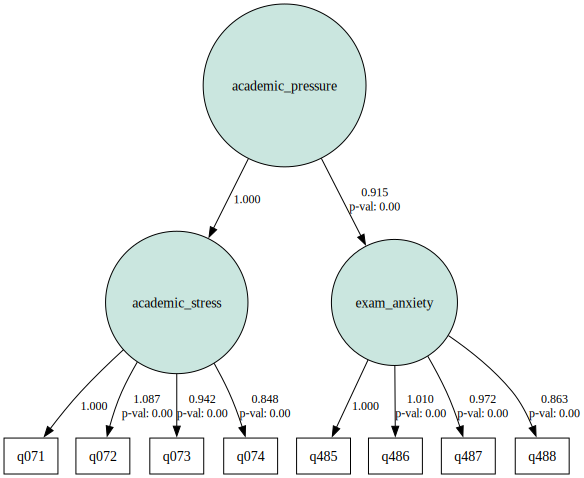

In [69]:
vif_df = compute_vif(df_edu, observed_vars)
model = Model(model_desc)
model = fit_sem_model(model, df_edu, w_cov_df)
stats = calc_stats(model)
estimates = model.inspect()
print("적합도 지표:\n", stats.T, "\n\n")
print("모수 추정치:\n", estimates)


semplot(model, 'C:\\git_files\\education_analysis\\happy\\academic_pressure.png')

In [70]:
vif_df = compute_vif(df_edu, observed_vars)

print(vif_df)

  Feature        VIF
0    q071  15.370539
1    q072  16.796847
2    q073   9.439047
3    q074   6.329149
4    q485   5.635447
5    q486   7.740921
6    q487   5.015247
7    q488   5.203326


In [71]:
factor_scores = model.predict_factors(df_edu)

df["academic_pressure"] = factor_scores["academic_pressure"]

print(df.head())

        id sex  birthy birthm             area         size school grade  \
0  20001.0  여성  2003.0     4월  충청권(대전, 충남, 충북)  도서벽지 및 읍면지역   고등학생   3학년   
1  20002.0  여성  2003.0     8월  충청권(대전, 충남, 충북)  도서벽지 및 읍면지역   고등학생   3학년   
2  20003.0  여성  2003.0     9월  충청권(대전, 충남, 충북)  도서벽지 및 읍면지역   고등학생   3학년   
3  20004.0  남성  2003.0     8월  충청권(대전, 충남, 충북)  도서벽지 및 읍면지역   고등학생   3학년   
4  20005.0  남성  2003.0     2월  충청권(대전, 충남, 충북)  도서벽지 및 읍면지역   고등학생   3학년   

  home1 home2  ...   q513   q514   q52   q53 q5411 q5412 q5421 q5422  \
0   아니오   아니오  ...  차이 없음  차이 없음  28.0  그대로다   NaN   NaN   NaN   NaN   
1     예     예  ...  차이 없음  차이 없음  20.0  그대로다   NaN   NaN   NaN   NaN   
2     예     예  ...  차이 없음  차이 없음  30.0  그대로다   NaN   NaN   NaN   NaN   
3     예     예  ...  차이 없음  차이 없음  30.0  그대로다   NaN   NaN   NaN   NaN   
4   아니오     예  ...  차이 없음  차이 없음  30.0  그대로다   NaN   NaN   NaN   NaN   

         wt academic_pressure  
0  0.250048         -0.253851  
1  0.250048         -0.173952  
2  0.250048   

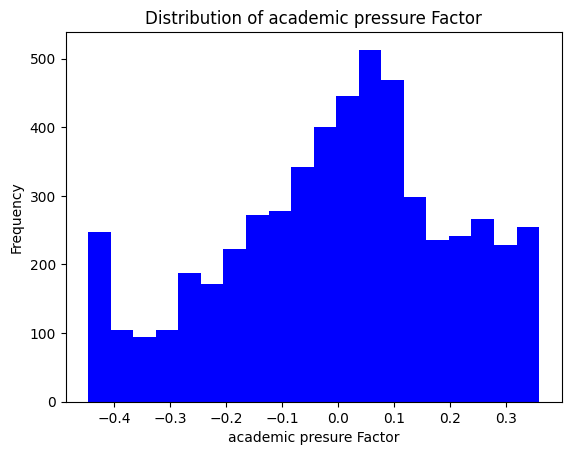

In [72]:
plt.hist(df["academic_pressure"], bins=20, color='blue')
plt.title("Distribution of academic pressure Factor")
plt.xlabel("academic presure Factor")
plt.ylabel("Frequency")
plt.show()

# 인간 관계

In [73]:
df_rel = df[['q05', 'q136','q061','q062','q161','q163','q164','q171','q173','q174','q224','q225', 'q132']]
df_rel.columns

Index(['q05', 'q136', 'q061', 'q062', 'q161', 'q163', 'q164', 'q171', 'q173',
       'q174', 'q224', 'q225', 'q132'],
      dtype='object')

In [74]:
df_rel = not_applicable(df_rel, ['q132', 'q136','q171', 'q161', 'q163', 'q164', 'q173', 'q174', 'q224'])
df_rel = encoding(df_rel, ['q05', 'q136','q061','q062','q161','q163','q164','q171','q173','q174','q224','q225'], category5_map)
df_rel = encoding(df_rel, ['q132'], reverse_category5_map)
df_rel = pd.DataFrame(scaler.fit_transform(df_rel), columns=df_rel.columns)
df_rel.head(3)

,q05,q136,q061,q062,q161,q163,q164,q171,q173,q174,q224,q225,q132
0,1.00,1.0,0.75,0.00,1.0,1.00,0.25,1.0,1.00,0.25,0.50,0.25,1.0
1,0.75,1.0,0.75,0.25,1.0,1.00,0.75,1.0,1.00,0.75,0.75,0.75,1.0
2,1.00,0.0,1.00,1.00,1.0,0.75,0.75,0.5,0.75,0.50,0.50,1.00,1.0


In [75]:
model_desc = """
friend_rel =~ q132 + q136
teacher_rel =~ q061 + q062
father_rel =~ q161 + q163
mother_rel =~ q171 + q173
group_rel =~ q224 + q225

human_rel =~ friend_rel + teacher_rel + father_rel + mother_rel + group_rel

father_rel ~~ mother_rel
"""

In [76]:
df_rel['wt'] = df['wt']
observed_vars = ['q132', 'q136', 'q061', 'q062', 'q161', 'q163', 'q171','q173', 'q224', 'q225']
w_cov_df = calculate_covariance(df_rel, observed_vars)

적합도 지표:
                       Value
DoF               29.000000
DoF Baseline      45.000000
chi2             658.209326
chi2 p-value       0.000000
chi2 Baseline  15936.494396
CFI                0.960406
GFI                0.958698
AGFI               0.935911
NFI                0.958698
TLI                0.938561
RMSEA              0.063534
AIC               51.755130
BIC              223.087327
LogLik             0.122435 


모수 추정치:
            lval  op         rval  Estimate  Std. Err    z-value p-value
0    friend_rel   ~    human_rel  1.000000         -          -       -
1   teacher_rel   ~    human_rel  1.794071  0.103989  17.252581     0.0
2    father_rel   ~    human_rel  1.290233  0.083021  15.541102     0.0
3    mother_rel   ~    human_rel  1.052752  0.066343  15.868427     0.0
4     group_rel   ~    human_rel  2.194070   0.13792  15.908298     0.0
5          q132   ~   friend_rel  1.000000         -          -       -
6          q136   ~   friend_rel  1.363978  0.082112   

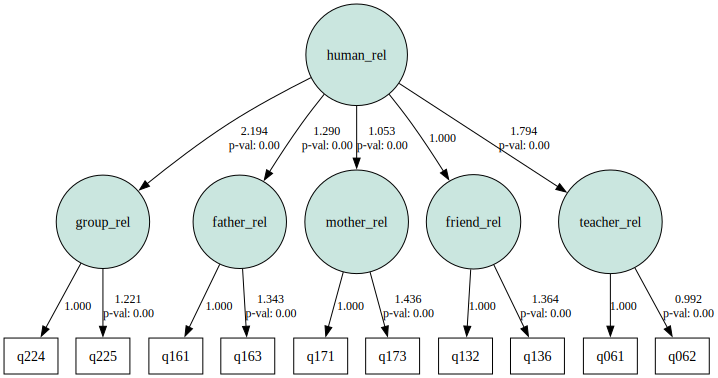

In [77]:
vif_df = compute_vif(df_rel, observed_vars)
model = Model(model_desc)
model = fit_sem_model(model, df_rel, w_cov_df)
stats = calc_stats(model)
estimates = model.inspect()
print("적합도 지표:\n", stats.T, "\n\n")
print("모수 추정치:\n", estimates)

semplot(model, 'C:\\git_files\\education_analysis\\happy\\human_rel.png')

In [78]:
vif_df = compute_vif(df_rel, observed_vars)

print(vif_df)

  Feature        VIF
0    q132  15.117122
1    q136  10.727763
2    q061  16.311566
3    q062   6.878076
4    q161  22.555441
5    q163  16.052997
6    q171  36.485988
7    q173  23.910469
8    q224   8.126710
9    q225  13.759303


In [79]:
factor_scores = model.predict_factors(df_rel)

df["human_rel"] = factor_scores["human_rel"]

print(df.head())

        id sex  birthy birthm             area         size school grade  \
0  20001.0  여성  2003.0     4월  충청권(대전, 충남, 충북)  도서벽지 및 읍면지역   고등학생   3학년   
1  20002.0  여성  2003.0     8월  충청권(대전, 충남, 충북)  도서벽지 및 읍면지역   고등학생   3학년   
2  20003.0  여성  2003.0     9월  충청권(대전, 충남, 충북)  도서벽지 및 읍면지역   고등학생   3학년   
3  20004.0  남성  2003.0     8월  충청권(대전, 충남, 충북)  도서벽지 및 읍면지역   고등학생   3학년   
4  20005.0  남성  2003.0     2월  충청권(대전, 충남, 충북)  도서벽지 및 읍면지역   고등학생   3학년   

  home1 home2  ...   q514   q52   q53 q5411 q5412 q5421 q5422        wt  \
0   아니오   아니오  ...  차이 없음  28.0  그대로다   NaN   NaN   NaN   NaN  0.250048   
1     예     예  ...  차이 없음  20.0  그대로다   NaN   NaN   NaN   NaN  0.250048   
2     예     예  ...  차이 없음  30.0  그대로다   NaN   NaN   NaN   NaN  0.250048   
3     예     예  ...  차이 없음  30.0  그대로다   NaN   NaN   NaN   NaN  0.244036   
4   아니오     예  ...  차이 없음  30.0  그대로다   NaN   NaN   NaN   NaN  0.244036   

  academic_pressure human_rel  
0         -0.253851 -0.045746  
1         -0.173952  0.02573

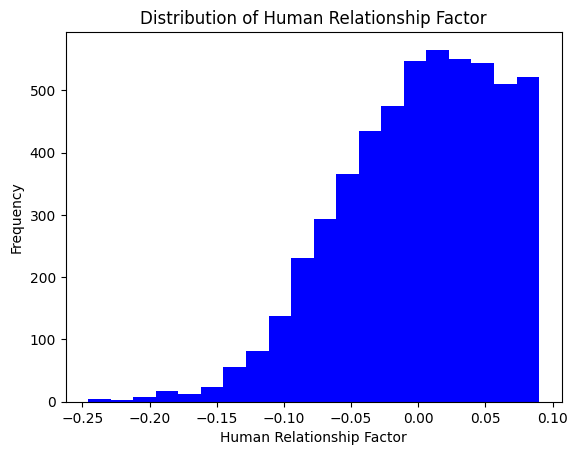

In [80]:
plt.hist(df["human_rel"], bins=20, color='blue')
plt.title("Distribution of Human Relationship Factor")
plt.xlabel("Human Relationship Factor")
plt.ylabel("Frequency")
plt.show()

# 정서적 상태

In [81]:
emo = df[['q221', 'q222', 'q223', 'q226', 'q23', 'q26']]
emo.isnull().sum()

q221    0
q222    0
q223    0
q226    0
q23     0
q26     0
dtype: int64

In [82]:
for i in emo.columns:
    display(emo[i].value_counts())

q221
매우 그렇다       1998
조금 그렇다       1508
보통이다         1225
별로 그렇지 않다     506
전혀 그렇지 않다     139
Name: count, dtype: int64

q222
매우 그렇다       1815
조금 그렇다       1546
보통이다         1256
별로 그렇지 않다     507
전혀 그렇지 않다     252
Name: count, dtype: int64

q223
매우 그렇다       1605
조금 그렇다       1464
보통이다         1454
별로 그렇지 않다     610
전혀 그렇지 않다     243
Name: count, dtype: int64

q226
전혀 그렇지 않다    1575
별로 그렇지 않다    1463
보통이다         1150
조금 그렇다        798
매우 그렇다        390
Name: count, dtype: int64

q23
대체로 행복한 편이다       3106
매우 행복하다           1063
별로 행복하지 않은 편이다     708
모르겠다               388
전혀 행복하지 않다         111
Name: count, dtype: int64

q26
보통이다       1865
약간 행복하다    1450
매우 행복하다    1340
약간 불행하다     575
매우 불행하다     146
Name: count, dtype: int64

In [83]:
emo = encoding(emo, ['q221', 'q222', 'q223'], category5_map)
emo = encoding(emo, ['q226'], reverse_category5_map)
emo = encoding(emo, ['q23'], happy_map)
emo = encoding(emo, ['q26'], how_happy_map)

In [84]:
scaler = MinMaxScaler()
emo = pd.DataFrame(scaler.fit_transform(emo), columns=emo.columns)

In [85]:
model_desc = """
emotional_state =~ q221 + q223 + q226 + q23
"""

In [86]:
emo['wt'] = df['wt']
observed_vars = ['q221', 'q223', 'q226', 'q23']
w_cov_df = calculate_covariance(emo, observed_vars)

적합도 지표:
                      Value
DoF               2.000000
DoF Baseline      6.000000
chi2             22.569467
chi2 p-value      0.000013
chi2 Baseline  5595.678654
CFI               0.996320
GFI               0.995967
AGFI              0.987900
NFI               0.995967
TLI               0.988960
RMSEA             0.043743
AIC              15.991604
BIC              68.709203
LogLik            0.004198 


모수 추정치:
               lval  op             rval  Estimate  Std. Err    z-value p-value
0             q221   ~  emotional_state  1.000000         -          -       -
1             q223   ~  emotional_state  1.542916  0.039907  38.662765     0.0
2             q226   ~  emotional_state  0.957764  0.032574  29.403152     0.0
3              q23   ~  emotional_state  1.093968  0.028468  38.427411     0.0
4  emotional_state  ~~  emotional_state  0.025571  0.001206  21.202969     0.0
5             q221  ~~             q221  0.049857   0.00109  45.754518     0.0
6             q223  ~

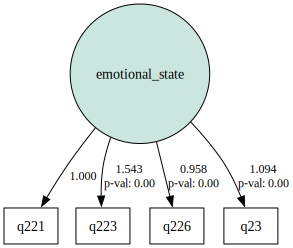

In [87]:
vif_df = compute_vif(emo, observed_vars)
model = Model(model_desc)
model = fit_sem_model(model, emo, w_cov_df)
stats = calc_stats(model)
estimates = model.inspect()
print("적합도 지표:\n", stats.T, "\n\n")
print("모수 추정치:\n", estimates)


semplot(model, 'C:\\git_files\\education_analysis\\happy\\emotional_state.png')

In [88]:
factor_scores = model.predict_factors(emo)

df["emotional_state"] = factor_scores["emotional_state"]

print(df.head())

        id sex  birthy birthm             area         size school grade  \
0  20001.0  여성  2003.0     4월  충청권(대전, 충남, 충북)  도서벽지 및 읍면지역   고등학생   3학년   
1  20002.0  여성  2003.0     8월  충청권(대전, 충남, 충북)  도서벽지 및 읍면지역   고등학생   3학년   
2  20003.0  여성  2003.0     9월  충청권(대전, 충남, 충북)  도서벽지 및 읍면지역   고등학생   3학년   
3  20004.0  남성  2003.0     8월  충청권(대전, 충남, 충북)  도서벽지 및 읍면지역   고등학생   3학년   
4  20005.0  남성  2003.0     2월  충청권(대전, 충남, 충북)  도서벽지 및 읍면지역   고등학생   3학년   

  home1 home2  ...   q52   q53 q5411 q5412 q5421 q5422        wt  \
0   아니오   아니오  ...  28.0  그대로다   NaN   NaN   NaN   NaN  0.250048   
1     예     예  ...  20.0  그대로다   NaN   NaN   NaN   NaN  0.250048   
2     예     예  ...  30.0  그대로다   NaN   NaN   NaN   NaN  0.250048   
3     예     예  ...  30.0  그대로다   NaN   NaN   NaN   NaN  0.244036   
4   아니오     예  ...  30.0  그대로다   NaN   NaN   NaN   NaN  0.244036   

  academic_pressure human_rel emotional_state  
0         -0.253851 -0.045746       -0.167932  
1         -0.173952  0.025737        0

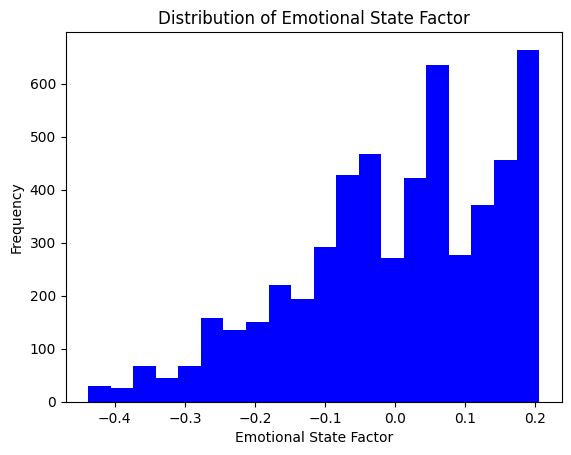

In [89]:
plt.hist(df["emotional_state"], bins=20, color='blue')
plt.title("Distribution of Emotional State Factor")
plt.xlabel("Emotional State Factor")
plt.ylabel("Frequency")
plt.show()

In [90]:
vif_df = compute_vif(emo, observed_vars)

print(vif_df)

  Feature        VIF
0    q221   9.220417
1    q223  12.683975
2    q226   5.976266
3     q23  13.798079
